# Model Training v5 - Getaround Pricing Project

Ce notebook implémente un pipeline complet pour le projet de prédiction du prix de location journalière. Il inclut le chargement, l'exploration, le nettoyage, la préparation, la modélisation avec GridSearchCV, l'évaluation et la sauvegarde du modèle. Le but est de disposer d'un modèle robuste et intégré qui pourra être facilement utilisé dans l'API FastAPI.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Pour une bonne visualisation dans le notebook
%matplotlib inline

## Chargement des données

Les données sont chargées à partir du fichier `../data/get_around_pricing_project.csv`.

In [10]:
data_path = "../data/get_around_pricing_project.csv"
df = pd.read_csv(data_path)
print(f"Shape du dataset : {df.shape}")
df.head()

Shape du dataset : (4843, 15)


,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


## Analyse Exploratoire des Données (EDA)

Affichage d'informations générales et statistiques descriptives. Visualisation de certaines distributions.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 4843 non-null   int64 
 1   model_key                  4843 non-null   object
 2   mileage                    4843 non-null   int64 
 3   engine_power               4843 non-null   int64 
 4   fuel                       4843 non-null   object
 5   paint_color                4843 non-null   object
 6   car_type                   4843 non-null   object
 7   private_parking_available  4843 non-null   bool  
 8   has_gps                    4843 non-null   bool  
 9   has_air_conditioning       4843 non-null   bool  
 10  automatic_car              4843 non-null   bool  
 11  has_getaround_connect      4843 non-null   bool  
 12  has_speed_regulator        4843 non-null   bool  
 13  winter_tires               4843 non-null   bool  
 14  rental_p

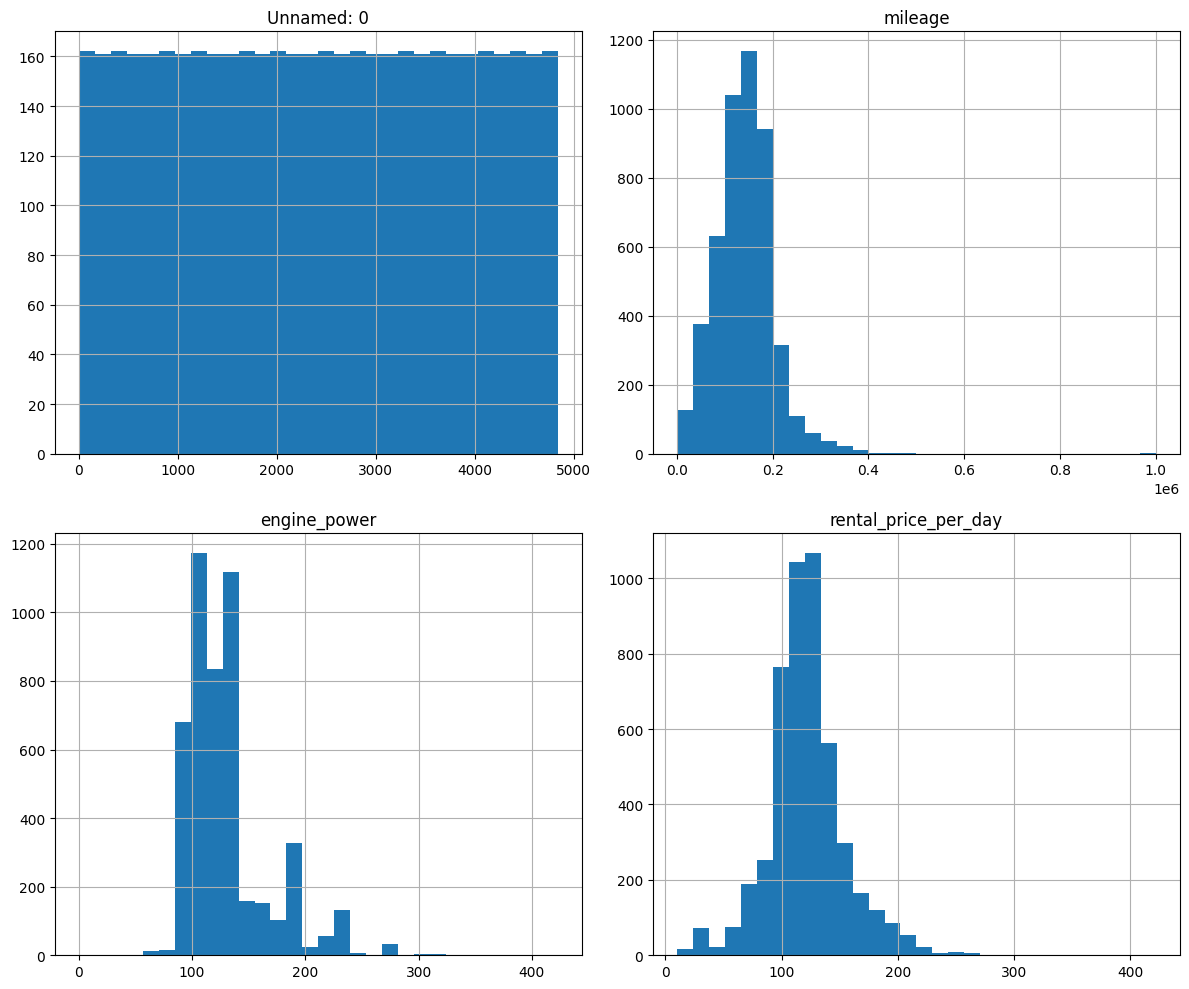

In [11]:
print(df.info())
print(df.describe())

# Visualisation des distributions numériques
df.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

## Nettoyage et Préparation des Données

Suppression des doublons, retrait de la colonne inutile `Unnamed: 0` et gestion des valeurs manquantes sur la colonne cible `rental_price_per_day`.

In [12]:
# Suppression des doublons
df = df.drop_duplicates()

# Suppression de la colonne 'Unnamed: 0' si présente
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Suppression des lignes où la cible 'rental_price_per_day' est manquante
df = df.dropna(subset=['rental_price_per_day'])

print(f"Nombre de lignes après nettoyage : {df.shape[0]}")

Nombre de lignes après nettoyage : 4843


## Séparation de l'Ensemble d'Entraînement et de Test

On sépare les données en variables explicatives (X) et cible (y). Ici, la cible est `rental_price_per_day`.
On effectue ensuite un split avec 80 % pour l'entraînement et 20 % pour le test.

In [13]:
# Définir X et y
X = df.drop('rental_price_per_day', axis=1)
y = df['rental_price_per_day']

# Optionnel : on peut également vérifier et transformer les colonnes non pertinentes si besoin

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Taille de l'ensemble d'entraînement : {X_train.shape}")
print(f"Taille de l'ensemble de test : {X_test.shape}")

Taille de l'ensemble d'entraînement : (3874, 13)
Taille de l'ensemble de test : (969, 13)


## Préparation des Pipelines de Prétraitement

On distingue ici les variables numériques et catégorielles. Pour les numériques, on utilise une imputation par la médiane suivie d'une standardisation. Pour les catégorielles, on utilise une imputation par la valeur constante `'missing'` et un OneHotEncoder pour transformer les variables en indicateurs.

In [14]:
# Identification automatique des colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Features numériques :", numeric_features)
print("Features catégorielles :", categorical_features)

# Pipeline pour les variables numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinaison des pipelines avec ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

Features numériques : ['mileage', 'engine_power']
Features catégorielles : ['model_key', 'fuel', 'paint_color', 'car_type']


## Création du Pipeline Complet avec le Modèle

On intègre le préprocesseur dans un pipeline complet avec le modèle RandomForestRegressor.

In [15]:
model = RandomForestRegressor(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

## Définition de la Grille d'Hyperparamètres et GridSearchCV

Nous définissons une grille d'hyperparamètres pour le RandomForest et utilisons GridSearchCV avec validation croisée pour trouver la meilleure combinaison.

In [16]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['mileage',
                                                                          'engine_power']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['model_key',
                                                                          'fuel',
                                                                          'paint_color',
                                                                          'car_type'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__n_estimators': [100, 200]},
             scoring='r2', verbose=2)

## Évaluation du Modèle

Nous évaluons le meilleur modèle trouvé sur l’ensemble de test en calculant le MSE et le R².

In [17]:
print("Meilleurs hyperparamètres :", grid_search.best_params_)

y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE : {mse}")
print(f"Test R2  : {r2}")

Meilleurs hyperparamètres : {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__n_estimators': 200}
Test MSE : 333.1901251929208
Test R2  : 0.6836473519163222


## Sauvegarde du Meilleur Modèle

Le modèle optimal est sauvegardé afin d'être utilisé par l'API FastAPI ultérieurement.

In [18]:
model_path = "../outputs/best_model_v5.joblib"
joblib.dump(grid_search.best_estimator_, model_path)
print(f"Modèle sauvegardé dans {model_path}")

Modèle sauvegardé dans ../outputs/best_model_v5.joblib


## Visualisation des Importances des Variables

Afin de vérifier que le modèle s'appuie sur les bonnes variables, nous affichons ici les importances en extrayant les noms des colonnes issues du préprocesseur (après transformation notamment avec le OneHotEncoder).

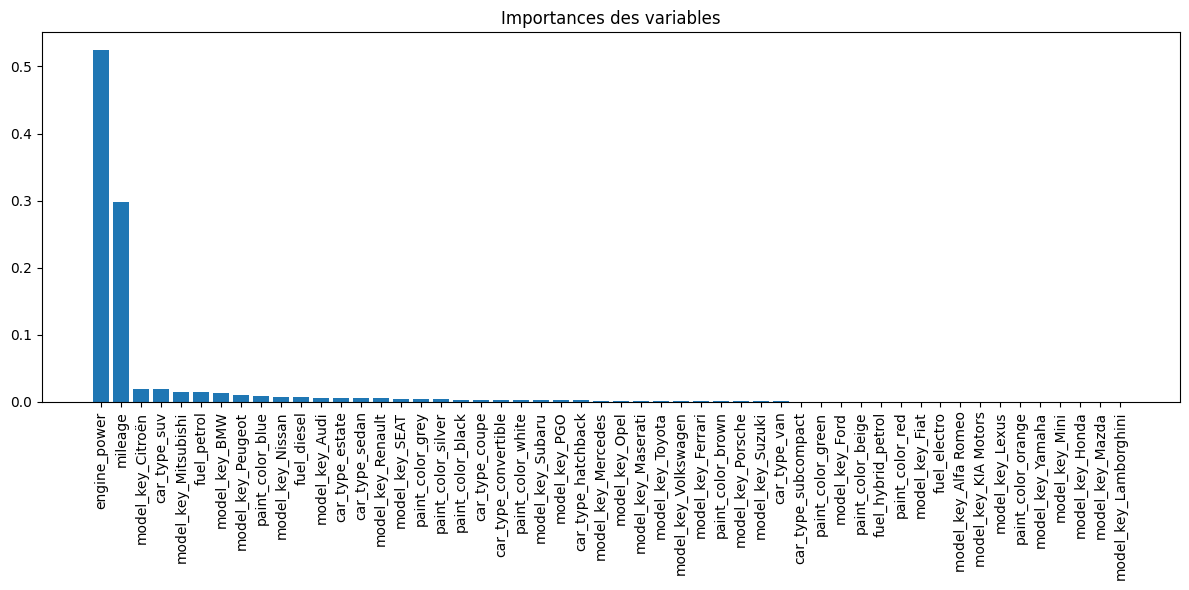

In [19]:
# Extraction des noms de variables après transformation
preprocessed_features = []

# Ajout des features numériques
preprocessed_features.extend(numeric_features)

# Extraction des features issues du OneHotEncoder pour les variables catégorielles
ohe = grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)
preprocessed_features.extend(cat_features)

# Récupération des importances depuis le modèle RandomForest
feature_importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Importances des variables")
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), np.array(preprocessed_features)[indices], rotation=90)
plt.tight_layout()
plt.show()

## Conclusion

Le notebook a exécuté l'ensemble du pipeline (chargement, nettoyage, préparation, modélisation, évaluation et sauvegarde) de manière complète. Le modèle sauvegardé dans `../outputs/best_model_v5.joblib` est prêt à être utilisé par l'API FastAPI.

N'oublie pas de vérifier la structure de ton projet et d'adapter les chemins d'accès si nécessaire.

In [20]:
feature_importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
importances_df = pd.DataFrame({
    'feature': preprocessed_features,  # ou la liste de features après encodage
    'importance': feature_importances
})
importances_df = importances_df.sort_values('importance', ascending=False)
print(importances_df)


                  feature  importance
1            engine_power    0.524698
0                 mileage    0.298428
5       model_key_Citroën    0.019639
50           car_type_suv    0.019237
17   model_key_Mitsubishi    0.014566
33            fuel_petrol    0.014396
4           model_key_BMW    0.012485
21      model_key_Peugeot    0.010544
36       paint_color_blue    0.008704
18       model_key_Nissan    0.007161
30            fuel_diesel    0.006765
3          model_key_Audi    0.006318
46        car_type_estate    0.005552
48         car_type_sedan    0.005484
23      model_key_Renault    0.005184
24         model_key_SEAT    0.003675
39       paint_color_grey    0.003663
42     paint_color_silver    0.003633
35      paint_color_black    0.003296
45         car_type_coupe    0.002902
44   car_type_convertible    0.002870
43      paint_color_white    0.002802
25       model_key_Subaru    0.002539
20          model_key_PGO    0.002059
47     car_type_hatchback    0.001995
15     model

Dataset shape après nettoyage : (4842, 14)
  model_key  mileage  engine_power    fuel paint_color     car_type  \
0   Citroën   140411           100  diesel       black  convertible   
1   Citroën    13929           317  petrol        grey  convertible   
2   Citroën   183297           120  diesel       white  convertible   
3   Citroën   128035           135  diesel         red  convertible   
4   Citroën    97097           160  diesel      silver  convertible   

   private_parking_available  has_gps  has_air_conditioning  automatic_car  \
0                       True     True                 False          False   
1                       True     True                 False          False   
2                      False    False                 False          False   
3                       True     True                 False          False   
4                       True     True                 False          False   

   has_getaround_connect  has_speed_regulator  winter_tires  

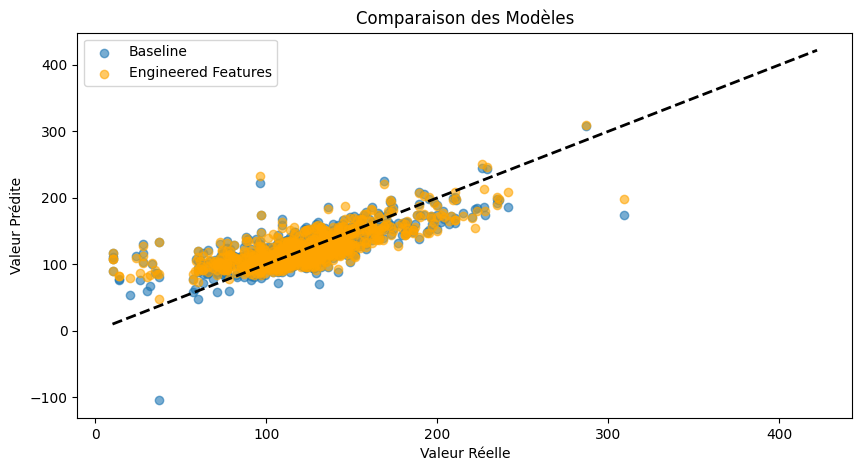

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# Chargement et nettoyage des données
# -----------------------------
data_path = "../data/get_around_pricing_project.csv"
df = pd.read_csv(data_path)

# Retirer la colonne 'Unnamed: 0' si elle existe et supprimer les doublons
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.drop_duplicates()

# Conversion en numérique pour les colonnes essentielles
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')
df['engine_power'] = pd.to_numeric(df['engine_power'], errors='coerce')

# Supprimer les lignes où la cible ou les features essentielles sont manquantes
df = df.dropna(subset=['rental_price_per_day', 'engine_power', 'mileage'])

# Filtrer pour ne garder que les valeurs valides pour mileage (>= 0)
df = df[df['mileage'] >= 0]

print("Dataset shape après nettoyage :", df.shape)
print(df.head())

# -----------------------------
# Test 1 : Baseline Linear Regression
# Utilisation de 'engine_power' et 'mileage'
# -----------------------------
X_baseline = df[['engine_power', 'mileage']]
y = df['rental_price_per_day']

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y, test_size=0.2, random_state=42)

# Entraînement du modèle linéaire de base
lr_baseline = LinearRegression()
lr_baseline.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_baseline = lr_baseline.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print("----- Baseline Linear Regression -----")
print("Test MSE:", mse_baseline)
print("Test R²:", r2_baseline)

# -----------------------------
# Test 2 : Linear Regression avec Feature Engineering
# Création des nouvelles features :
#    - ratio_power_mileage : ratio entre engine_power et mileage (+1 pour éviter la division par zéro)
#    - log_mileage        : transformation logarithmique du mileage
# -----------------------------
df['ratio_power_mileage'] = df['engine_power'] / (df['mileage'] + 1)
df['log_mileage'] = np.log1p(df['mileage'])

X_engineered = df[['engine_power', 'log_mileage', 'ratio_power_mileage']]
y = df['rental_price_per_day']

# Séparation train/test
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_engineered, y, test_size=0.2, random_state=42)

# Entraînement du modèle linéaire avec features ingénierisées
lr_eng = LinearRegression()
lr_eng.fit(X_train_eng, y_train_eng)

# Prédictions et évaluation
y_pred_eng = lr_eng.predict(X_test_eng)
mse_eng = mean_squared_error(y_test_eng, y_pred_eng)
r2_eng = r2_score(y_test_eng, y_pred_eng)

print("----- Linear Regression with Engineered Features -----")
print("Test MSE:", mse_eng)
print("Test R²:", r2_eng)

# -----------------------------
# Visualisation des prédictions
# -----------------------------
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_baseline, alpha=0.6, label="Baseline")
plt.scatter(y_test_eng, y_pred_eng, alpha=0.6, label="Engineered Features", color="orange")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Valeur Réelle")
plt.ylabel("Valeur Prédite")
plt.title("Comparaison des Modèles")
plt.legend()
plt.show()
